<a href="https://www.kaggle.com/code/tirendazacademy/experiment-tracking-with-comet-ml-pytorch?scriptVersionId=117373959" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>Intro to MLOps: Experiment Tracking with Comet ML & Pytorch</b></p>

![](https://github.com/TirendazAcademy/End-to-End-Deep-Learning-Projects/blob/main/image_classification_pytorch_comet/Images/images/dog-cat.png?raw=true)


This notebook walks you through how to build a CNN model for image classification with PyTorch and track an experiment with Comet.

<b>Table of contents:</b>
<ul>
<li><a href="#Introduction">Introduction</a></li>  
<li><a href="#Understanding">Understanding the dataset</a></li>         
<li><a href="#Loading-image-data">Loading image data</a></li>
<li><a href="#Building">Model building</a></li>
<li><a href="#Prediction">Make a prediction</a></li>
<li><a href="#Conclusion">Conclusion</a></li>
</ul>

Let's dive in!

<a id="Introduction"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>1. Introduction</b></p>

Before I start the analysis, let me explain what Pytorch and Comet are.

## What is Pytorch?

![](https://github.com/TirendazAcademy/End-to-End-Deep-Learning-Projects/blob/main/image_classification_pytorch_comet/Images/images/pytroch_features.png?raw=true)

PyTorch is a machine learning framework based on the Torch library,used for applications such as computer vision and natural language processing,originally developed by Meta AI and now part of the Linux Foundation umbrella. PyTorch is a great choice for deep learning projects because of its flexibility, ease of use, and strong community support.

## What is Comet ML?

![](https://github.com/TirendazAcademy/Comet-ML-Tutorials/blob/main/Images/comet-ml.png?raw=true)

Comet ML is a platform that allows developers and data scientists to track, compare, and optimize their machine learning experiments. It provides a simple interface to log code, metrics, and artifacts, and allows users to collaborate and share their work with others.

Nice, we have talked about some concepts we'll use in this notebook. Now, let's start an experiment with the Comet API key and log the hyperparameters we'll use for deep learning architecture. To do this, I'm going to use kaggle secret feature first as shown below:

In [1]:
# Setup user secrets for login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_api_key = user_secrets.get_secret("COMET_API_KEY")


#Install comet_ml
!pip install comet_ml

# import comet_ml at the top of your file
import comet_ml
from comet_ml import Experiment

## Create an experiment with your api key
experiment = Experiment(
    api_key= my_api_key,
    workspace="tirendaz-academy",
    project_name="experiment-tracking")

# Setting hyperparameters
hyper_params = {"seed": 42, "batch_size": 32, "num_epochs": 20, "learning_rate": 1e-3,"image_size": 224}
experiment.log_parameters(hyper_params)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.7/462.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.4/504.4 kB 40.6 MB/s eta 0:00:00


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/tirendaz-academy/experiment-tracking/06c342c91fe749a78b82bc90cfdbf996



Let's take a look at the version of the torch and check if Cuda exists.

In [2]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
print("The version of torch:", torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("The type of devise: ",device)

The version of torch: 1.11.0
The type of devise:  cuda


The dataset we will use for this tutorial is the cat and dog dataset, which contains images of cats and dogs. Let's take a look at the files in the dataset folder. To do this, let me create a function. 

In [3]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
image_path = "/kaggle/input/cat-and-dog"
walk_through_dir(image_path)

There are 2 directories and 0 images in '/kaggle/input/cat-and-dog'.
There are 1 directories and 0 images in '/kaggle/input/cat-and-dog/test_set'.
There are 2 directories and 0 images in '/kaggle/input/cat-and-dog/test_set/test_set'.
There are 0 directories and 1013 images in '/kaggle/input/cat-and-dog/test_set/test_set/dogs'.
There are 0 directories and 1012 images in '/kaggle/input/cat-and-dog/test_set/test_set/cats'.
There are 1 directories and 0 images in '/kaggle/input/cat-and-dog/training_set'.
There are 2 directories and 0 images in '/kaggle/input/cat-and-dog/training_set/training_set'.
There are 0 directories and 4006 images in '/kaggle/input/cat-and-dog/training_set/training_set/dogs'.
There are 0 directories and 4001 images in '/kaggle/input/cat-and-dog/training_set/training_set/cats'.


Nice! We saw the files in the dataset folder. Now let's create train and testing paths:

In [4]:
train_dir = "/kaggle/input/cat-and-dog/training_set/training_set"
test_dir = "/kaggle/input/cat-and-dog/test_set/test_set"
train_dir, test_dir

('/kaggle/input/cat-and-dog/training_set/training_set',
 '/kaggle/input/cat-and-dog/test_set/test_set')

<a id="Understanding"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>2. Understanding the Dataset</b></p>

It is important to understand the dataset for deep learning analysis because the dataset is the foundation of any machine learning or deep learning model. A deep learning model can only be as good as the data it is trained on, and a poor understanding of the dataset can lead to poor model performance or even bias. Now let's take a look at an image in the dataset. 

Random image path: /kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4202.jpg
Image class: cats
Image height: 217
Image width: 179


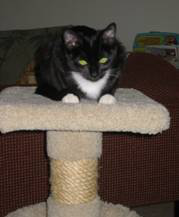

In [5]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(hyper_params["seed"]) 

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Beautiful cute cat isn't it? I love cats. So can't we use matplotlib for data visualization? Definitely yes. Let me show you.

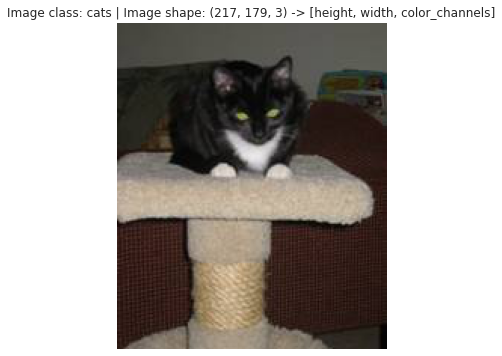

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

<a id="Loading-image-data"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>3. Loading Image Data</b></p>
So far, we've taken a look at the dataset. We are ready to load our dataset using this function. The easiest way to load data is to use the `ImageFolder` function in PyTorch. Let's load the dataset with this function. First, we're going to use data augmentation. Data augmentation is a technique used to artificially increase the size of a dataset by applying random modifications to the existing data. 

In [7]:
from torchvision import transforms
# Setting image size.
IMAGE_SIZE=(hyper_params["image_size"], hyper_params["image_size"])

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

Let's load images from train and test folders into a PyTorch dataset with the `ImageFolder` function.

In [8]:
from torchvision import datasets

# Turn image folders into Datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: /kaggle/input/cat-and-dog/training_set/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: /kaggle/input/cat-and-dog/test_set/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

Now let's turn Datasets into DataLoader's.

In [9]:
from torch.utils.data import DataLoader

# Setting some parameters
torch.manual_seed(hyper_params["seed"])
# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data,
                              batch_size=hyper_params["batch_size"], 
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=hyper_params["batch_size"], 
                             shuffle=False, 
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd796d1d350>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd791bfea50>)

Nice! We created the `DataLoader` objects. Let's go ahead and build an image classification architecture.

<a id="Building"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>4. Model Building</b></p>

To build our model, we're going to use an architecture based on convolutional neural network (CNN). The architecture of a CNN consists of several layers, including convolutional layers, pooling layers, and fully connected layers.

In [10]:
# Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2)) 
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x
# Instantiate an object.
model = ImageClassifier().to(device)

Ok, we created a CNN-based model. But does this model work? To understand this, let's pass a image through the model.

In [11]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0116, -0.0099]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4996, 0.5004]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


Nice! Our model is working for an image. Let's go ahead and try to understand this model with the `torchinfo` package 

In [12]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
# do a test pass through of an example input size 
summary(model, input_size=[1, 3, hyper_params["image_size"] ,hyper_params["image_size"]]) 

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,

Note that the model is built on the training data and tested on the validation set. Now let's create two function to train and test the model.

In [13]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # Logging train metrics
    experiment.log_metrics({"train_accuracy": train_acc, "train_loss": train_loss}, epoch=hyper_params['num_epochs'])
    return train_loss, train_acc

In [14]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    # Logging test metrics
    experiment.log_metrics({"test_accuracy": test_acc, "test_loss": test_loss}, epoch=hyper_params['num_epochs'])
    return test_loss, test_acc

Now let's create a function named train to combine the train_step and test_step functions.

In [15]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

So far, we created training and test steps. We are ready to train the model using these steps. Show time:

In [16]:
# Set random seeds
torch.manual_seed(hyper_params["seed"]) 
torch.cuda.manual_seed(hyper_params["seed"])

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyper_params["learning_rate"])

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Training the model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=hyper_params["num_epochs"])

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0101 | train_acc: 0.5716 | test_loss: 0.8615 | test_acc: 0.5797
Epoch: 2 | train_loss: 0.7881 | train_acc: 0.6071 | test_loss: 0.5760 | test_acc: 0.6850
Epoch: 3 | train_loss: 0.7306 | train_acc: 0.6538 | test_loss: 0.5840 | test_acc: 0.6832
Epoch: 4 | train_loss: 0.5898 | train_acc: 0.6952 | test_loss: 0.5116 | test_acc: 0.7457
Epoch: 5 | train_loss: 0.5373 | train_acc: 0.7289 | test_loss: 0.4648 | test_acc: 0.7812
Epoch: 6 | train_loss: 0.5118 | train_acc: 0.7472 | test_loss: 0.4732 | test_acc: 0.7750
Epoch: 7 | train_loss: 0.4457 | train_acc: 0.7827 | test_loss: 0.4273 | test_acc: 0.7985
Epoch: 8 | train_loss: 0.4112 | train_acc: 0.8081 | test_loss: 0.3879 | test_acc: 0.8288
Epoch: 9 | train_loss: 0.3587 | train_acc: 0.8361 | test_loss: 0.2763 | test_acc: 0.8876
Epoch: 10 | train_loss: 0.3276 | train_acc: 0.8523 | test_loss: 0.3786 | test_acc: 0.8164
Epoch: 11 | train_loss: 0.3292 | train_acc: 0.8523 | test_loss: 0.2589 | test_acc: 0.8943
Epoch: 12 | train_l

Beautiful. It's done. Now we had a model for image classification. To understand the performance of model, let's visualize the loss and accuracy values.

In [17]:
def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

It is time to visualize for the loss and accuracy values using this function.

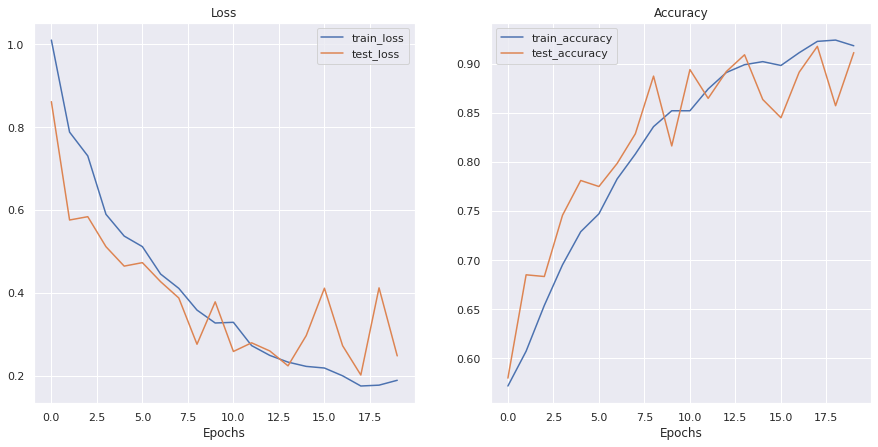

In [18]:
plot_loss_curves(model_results)

Awesome. The performance of our model is not bad on both the training and test datasets. Let's go ahead and take a look at how to make a prediction.

<a id="Prediction"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>5. Make a Prediction</b></p>

Now we had a good model for image classification. But, how does this model predict new data? To understand this let me make a prediction on a custom image. 

In [19]:
# Choose a image.
custom_image_path = "/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4001.jpg"

import torchvision
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.4941, 0.3059, 0.3059,  ..., 0.5490, 0.5412, 0.5451],
         [0.5333, 0.3451, 0.3059,  ..., 0.5490, 0.5451, 0.5490],
         [0.5686, 0.3961, 0.2980,  ..., 0.5490, 0.5451, 0.5490],
         ...,
         [0.6157, 0.6039, 0.6314,  ..., 0.6392, 0.6157, 0.5961],
         [0.6157, 0.6039, 0.6314,  ..., 0.6471, 0.6157, 0.5882],
         [0.6157, 0.6039, 0.6314,  ..., 0.6471, 0.6118, 0.5804]],

        [[0.4314, 0.2431, 0.2392,  ..., 0.5490, 0.5412, 0.5451],
         [0.4863, 0.2941, 0.2549,  ..., 0.5490, 0.5451, 0.5490],
         [0.5412, 0.3686, 0.2706,  ..., 0.5490, 0.5451, 0.5490],
         ...,
         [0.4784, 0.4667, 0.4941,  ..., 0.5608, 0.5373, 0.5176],
         [0.4784, 0.4667, 0.4941,  ..., 0.5686, 0.5373, 0.5098],
         [0.4784, 0.4667, 0.4941,  ..., 0.5686, 0.5333, 0.5020]],

        [[0.3333, 0.1529, 0.1686,  ..., 0.5804, 0.5725, 0.5765],
         [0.4000, 0.2196, 0.1882,  ..., 0.5804, 0.5765, 0.5804],
         [0.4667, 0.2980, 0.2078,  ..

Now let's create transform pipleine to resize image.

In [20]:
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 499, 421])
New shape: torch.Size([3, 224, 224])


First, let's fit the image for the model with the function we created and then make a prediction.

In [21]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


Now let's take a look at our model's predictions.

In [22]:
custom_image_pred

tensor([[-2.8982,  2.5484]], device='cuda:0')

Nice! we've seen the prediction values of the model. Let's take a look at the prediction class. First, let me show you the prediction values.

In [23]:
# Let's convert them from logits -> prediction probabilities -> prediction labels
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-2.8982,  2.5484]], device='cuda:0')
Prediction probabilities: tensor([[0.0043, 0.9957]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


It is time to find the predicted label.

In [24]:
class_names = train_data.classes
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'dogs'

Let's visualize this image with matplotlib.

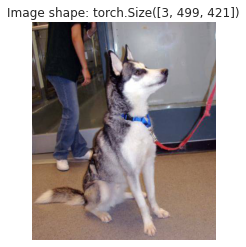

In [25]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [26]:
# Save the model for inference
from comet_ml.integration.pytorch import log_model
log_model(experiment, model, model_name="My_Image_Classification_Model")

In [27]:
# Ending our experiment
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tirendaz-academy/experiment-tracking/06c342c91fe749a78b82bc90cfdbf996
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [502]          : (0.030617356300354004, 1.7046949863433838)
COMET INFO:     test_accuracy [20]  : (0.5796595982142857, 0.91796875)
COMET INFO:     test_loss [20]      : (0.2021278360771248, 0.8615083671174943)
COMET INFO:     train_accuracy [20] : (0.5715886454183267, 0.9243774900398407)
COMET INFO:     train_loss [20]     : (0.17560719058986204, 1.0100663334012507)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     image_size    : 224
COMET INFO:     learning_rate : 0.001
COMET INFO:     num_epochs    : 20
COMET INFO:     seed          : 42
COMET INFO:   Uploads:
COMET INFO:     conda-envi

<a id="Prediction"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>6. Conclusion</b></p>

Experiment tracking is a powerful tool that helps researchers and engineers to improve their models and to make data-driven decisions. In this notebook, you learned how to track an experiment with Comet ML and build an image classification model from scratch with Pytorch. Tensorflow is generally preferred for deep learning projects. However, with Pytorch you can better control the deep-learning analysis steps. Pytorch has been preferred more recently, especially in the academic community. we also talked about data augmentation and highlighted the importance of this technique. I hope you like it. Let me know if you have any questions.

# Resources

- [Learn Pytorch](https://www.learnpytorch.io/)
- [Modern Computer Vision with PyTorch](https://www.amazon.com/Modern-Computer-Vision-PyTorch-applications/dp/1839213477)

📌 Thank you for reading 😀 If you like this notebook, don't forget to upvote it 😊

🔗 Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) |[GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎